Importar as bibliotecas

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import nltk
import string
import re
import os
import mpld3
import codecs
import joblib
import random
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import json
import networkx as nx
from networkx.readwrite import json_graph
from itertools import combinations
from fuzzywuzzy.process import extractBests
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from gensim import corpora, models, similarities 
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import cluster, mixture, metrics
from sklearn import feature_extraction
from sklearn.manifold import MDS
from sklearn.datasets import make_blobs
from sklearn.decomposition import NMF
from yellowbrick.text import TSNEVisualizer
from yellowbrick.text import UMAPVisualizer
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from scipy.cluster.hierarchy import ward, dendrogram
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
%matplotlib inline

VARIAVEIS

In [2]:
article_num = 100
filename = 'sportorbusiness.csv'
var_titulo = 'field3'
var_autor = 'field2'
var_publicacao = 'field4'
var_conteudo = 'field1'
num_palavras = 50 # quantidade de palavras p/ visualização
estimativa_categorias = 2 #estimativa de quantidade de categorias
noticia_procurar = 4 #id da noticia para recomendador
num_clusters = 5 #para kmeans,
epsilon = 1.1 #para DBSCAN
min_noticias = 10 # para OPTICS
modelo = 'kmeans' #escolhe o algoritmo a ser posto no visuazizador ex kmeans,affinity_propagation,meanshift,spectralclustering,ward,agglomerativeclustering,dbscan,optics,birch,minibatchkmeans

Importar datasets (Fonte Kaggle/Andrew Thompson)

In [3]:
n = sum(1 for line in open(filename,encoding="utf8"))-1
skip = sorted(random.sample(range(1, n+1), n-article_num))
dataset = pd.read_csv(filename, skiprows=skip)
dataset.head()

,field1,field2,field3,field4
0,SYDNEY: Oil prices fell 1 percent on Wednesday...,1/14/2015,oil extends losses as world bank cuts growth for,business
1,London: Oil prices advanced further Monday wit...,2/9/2015,oil prices extend gai,business
2,LONDON: British bank HSBC Holdings Plc admitte...,2/9/2015,hsbc admits swiss bank failings over client tax,business
3,ISLAMABAD: Ambassador of Tajikistan Sher Ali J...,2/27/2015,tajikistan to help pakistan overcome energy cr...,business
4,"Hong Kong: Asian markets rallied Wednesday, le...",4/8/2015,asian shares rise hong kong at seven year hig,business


Carrega base de stopwords do nltk

In [4]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['u',"'s",'wa','le','ha',"n't",'said','told',"'d", "'ll", "'re", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would','br/']
stopwords.extend(newStopWords)

Carrega base snowball para stemming

In [5]:
stemmer = SnowballStemmer("english")

Criação de funçoes para stemming e tokenizer

In [6]:
def tokenize_and_stem(texto):
    # tokeniza por sentença
    tokens = [word for sent in nltk.sent_tokenize(texto) for word in nltk.word_tokenize(sent)]
    filtro_tokens = []
    # filtra tokens que nao sao letras
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtro_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtro_tokens]
    return stems

def tokenize_and_lemmatizer(texto):
    lemmatizer = WordNetLemmatizer() 
    # tokeniza por sentença
    tokens = [word for sent in nltk.sent_tokenize(texto) for word in nltk.word_tokenize(sent)]
    filtro_tokens = []
    # filtra tokens que nao sao letras
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtro_tokens.append(token)
    lemma = [lemmatizer.lemmatize(t) for t in filtro_tokens]
    return lemma

def tokenize_only(texto):
    # tokeniza por sentença
    tokens = [word.lower() for sent in nltk.sent_tokenize(texto) for word in nltk.word_tokenize(sent)]
    filtro_tokens = []
    # filtra tokens que nao sao letras
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtro_tokens.append(token)
    return filtro_tokens

passa o conteudo das noticias pelos filtros para criar dois vocabularios, um somente tokenizado e um stemmizado e tokenizado

In [7]:
corpo = dataset[var_conteudo]
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in corpo:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Cria um dataframe com o vocabulario stemmizado como index e o vocabulario tokenizado como coluna para optimizar pesquisa

In [8]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

Utiliza TF-IDF para vetorizar artigos

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_df=1.2, max_features=200000,
                                 min_df=0.1, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_lemmatizer, ngram_range=(1,3))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(corpo)
print(tfidf_matrix.shape)

Wall time: 3.11 s
(100, 232)


In [10]:
terms = tfidf_vectorizer.get_feature_names()

In [11]:
dist = 1 - cosine_similarity(tfidf_matrix)

Aplica algoritmo KMeans

In [12]:
tfidf_matrix = tfidf_matrix.toarray()
if modelo == 'meanshift':
    model =  cluster.MeanShift()
    bandwidth = cluster.estimate_bandwidth(tfidf_matrix, quantile=0.8, n_samples=article_num)
    ms =  cluster.MeanShift(bandwidth=2, bin_seeding=True, cluster_all=True, min_bin_freq=1,
     n_jobs=None, seeds=None)
    %time ms.fit(tfidf_matrix)
    clusters = ms.labels_.tolist()
    alg = ms
if modelo == 'spectralclustering':
    model =  cluster.SpectralClustering()
    sc =  cluster.SpectralClustering(n_clusters = num_clusters, eigen_solver='arpack')
    %time sc.fit(tfidf_matrix)
    clusters = sc.labels_.tolist()
    alg = sc
if modelo == 'ward':
    model =  cluster.AgglomerativeClustering()
    ward1 =  cluster.AgglomerativeClustering(n_clusters = num_clusters,linkage='ward')
    %time ward1.fit(tfidf_matrix)
    clusters = ward1.labels_.tolist()
    alg = ward1
if modelo == 'agglomerativeclustering':
    model =  cluster.AgglomerativeClustering()
    ac =  cluster.AgglomerativeClustering(linkage='average',affinity='cityblock',n_clusters=num_clusters)
    %time ac.fit(tfidf_matrix)
    clusters = ac.labels_.tolist()
    alg = ac
if modelo == 'dbscan':
    model =  cluster.DBSCAN()
    dbs =  cluster.DBSCAN(eps=epsilon)
    %time dbs.fit(tfidf_matrix)
    clusters = dbs.labels_.tolist()
    alg = dbs
if modelo == 'optics':
    model =  cluster.OPTICS()
    optics =  cluster.OPTICS(min_samples=min_noticias)
    %time optics.fit(tfidf_matrix)
    clusters = optics.labels_.tolist()
    alg = optics
if modelo == 'birch':
    model =  cluster.Birch()
    birch =  cluster.Birch(n_clusters=num_clusters)
    %time birch.fit(tfidf_matrix)
    clusters = birch.labels_.tolist()
    alg = birch
if modelo == 'affinity_propagation':
    model =  cluster.AffinityPropagation()
    ap =  cluster.AffinityPropagation()
    %time ap.fit(tfidf_matrix)
    clusters = ap.labels_.tolist()
    alg = ap
if modelo == 'kmeans':
    model =  cluster.KMeans()
    km =  cluster.KMeans(n_clusters=num_clusters)
    %time km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    alg = km
if modelo == 'minibatchkmeans':
    model =  cluster.MiniBatchKMeans()
    minikm =  cluster.MiniBatchKMeans(n_clusters=num_clusters)
    %time minikm.fit(tfidf_matrix)
    clusters = minikm.labels_.tolist()
    alg = minikm

Wall time: 52 ms


In [13]:
labels = alg.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 5


Demonstra Elbow Method

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


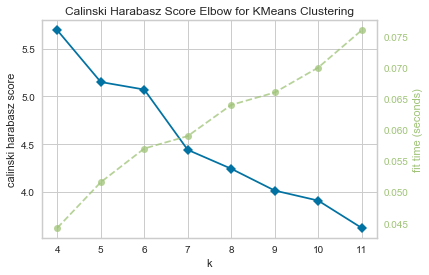

In [14]:
if modelo == 'kmeans' or modelo == 'minibatchkmeans':
    visualizer = KElbowVisualizer(model, k=(4,12),metric='calinski_harabasz')
    visualizer.fit(tfidf_matrix)
    visualizer.poof()
    #descomentar para salvar grafico
    #visualizer.poof(outpath="kelbow_minibatchkmeanscalinski.png")

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


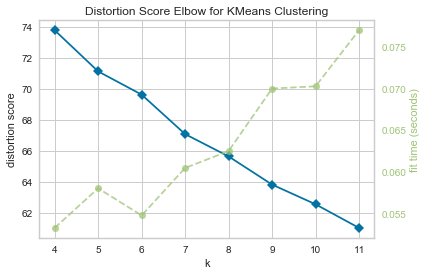

In [15]:
if modelo == 'kmeans' or modelo == 'minibatchkmeans':
    visualizer = KElbowVisualizer(model, k=(4,12))
    visualizer.fit(tfidf_matrix)
    visualizer.poof()
    #descomentar para salvar grafico
    #visualizer.poof(outpath="kelbow_minibatchkmeans.png")

Demonstra InterclusterDistance

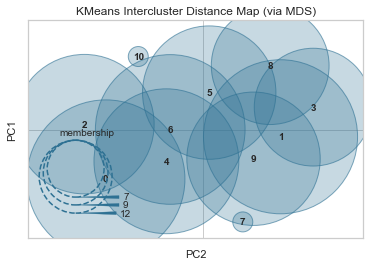

In [16]:
if modelo == 'kmeans' or modelo == 'minibatchkmeans' or modelo == 'affinity_propagation':
    visualizer1 = InterclusterDistance(model)
    visualizer1.fit(tfidf_matrix)
    visualizer1.poof()
    #descomentar para salvar grafico
    #visualizer.poof(outpath="intercluster.png")

Demonstra SilhouetteVisualizer

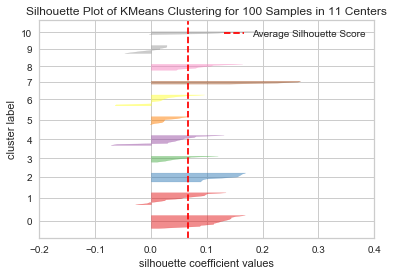

In [17]:
if modelo == 'kmeans' or modelo == 'minibatchkmeans':
    visualizer3 = SilhouetteVisualizer(model)
    visualizer3.fit(tfidf_matrix)
    visualizer3.poof()
    #descomentar para salvar grafico
    #visualizer.poof(outpath="SilhouetteVisualizer.png")

Guarda em dataframe

In [18]:
titulo = dataset[var_titulo]
autor = dataset[var_autor]
publicacao = dataset[var_publicacao]
noticias = { 'title': titulo, 'author': autor, 'content': corpo, 'cluster': clusters, 'publication': publicacao }
frame = pd.DataFrame(noticias, index = [clusters] , columns = ['title', 'author', 'cluster', 'publication'])

In [19]:
#monstra com o centro dos clusters
if modelo == 'kmeans' or modelo == 'minibatchkmeans' or modelo == 'affinity_propagation':
    print("Top terms per cluster:")
    print()
    order_centroids = alg.cluster_centers_.argsort()[:, ::-1]
    for i in range(num_clusters):
        print("Cluster %d words:" % i, end='')
        for ind in order_centroids[i, :num_palavras]:
            print(' %s' % terms[ind], end=',')
        print()
        print()
        print("Cluster %d titles:" % i, end='')
        for title in noticias['title'].values.tolist():
            print(' %s,\n' % title, end='')
        print()
        print()

Top terms per cluster:

Cluster 0 words: run, champion, world, first, player, south, four, match, twenty20, captain, two, last, team, second, batsman, group, six, one, made, ball, west, strong, bowler, day, game, start, three, inning, leading, tournament, international, stadium, year, best, ahead, get, long, like, want, top, also, final, united, series, five, cup, took, new, point, time,

Cluster 0 titles: oil extends losses as world bank cuts growth for,
 oil prices extend gai,
 hsbc admits swiss bank failings over client tax,
 tajikistan to help pakistan overcome energy crisis through kasa 1000 proj,
 asian shares rise hong kong at seven year hig,
 sbp maintains discount r,
 gold struggles near multi year,
 investments heat up online news sector,
 oil prices up in asian trad,
 state bank announces monetary policy,
 oil up in asia but oversupply weak demand weig,
 Oil prices weaken US crude defends premium over Br,
 Power sector recoveries stand at 93 pcin 2015 Asif,
 Saudi Iran split

Redução de dimensão

In [20]:
MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

In [21]:
def strip_proppers_POS(text):
    tagged = pos_tag(text.split())
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

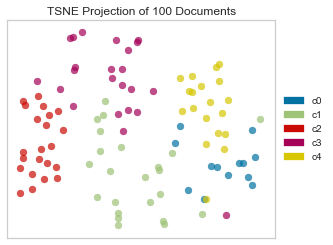

In [22]:
X = tfidf_matrix

clusters = alg
clusters.fit(X)

tsne = TSNEVisualizer()
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()
#descomentar para salvar grafico
#visualizer.poof(outpath="TSNE.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

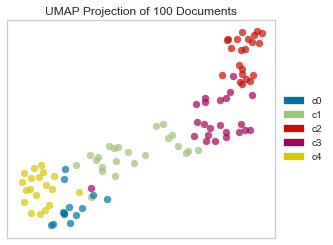

In [23]:
umap = UMAPVisualizer()
umap.fit(X, ["c{}".format(c) for c in clusters.labels_])
umap.poof()
#descomentar para salvar grafico
#visualizer.poof(outpath="UMAP.png")

Visualização

In [24]:
%matplotlib inline

In [25]:
#bug com affinity_propagation
cluster_colors = {}
#caso queira nomear manualmente remover comentario
#cluster_names = {0: Nome1, 1: Nome2,2: Nome3}
cluster_name = {}
for i in range (0,num_clusters):
    cluster_colors[i] = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    cluster_name[i] = 'Rotulo',i

class TopToolbar(mpld3.plugins.PluginBase):
    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 200);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [26]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=alg.labels_, title=dataset[var_titulo])) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -100px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(17,9)) #set plot size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_name[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

Recomendador de artigos similares

In [27]:
similarity = np.dot(tfidf_matrix[noticia_procurar],np.transpose(tfidf_matrix))
x = similarity
print(dataset[var_titulo][noticia_procurar])
print('\nsimiliar papers:')
print('\n'.join(dataset[var_titulo].loc[np.argsort(x)[-10:-2]]))

asian shares rise hong kong at seven year hig

similiar papers:
Oil falls as traders cash in after 3 weeks of gai
oil extends losses as world bank cuts growth for
Dollar jumps Clinton gets eleventh hour election b
Gold hits three month high on shaky global economy
state bank announces monetary policy
Asia stocks slip in holiday thinned trad
Asian shares slip from three week high as oil rally rever
Gold drops three week low investors equiti


Ward Hierarchical Clustering

In [28]:
if model == 'ward' or model == 'agglomerativeclustering':
    titulo_lista = dataset[var_titulo].tolist()
    linkage_matrix = ward(dist)
    fig, ax = plt.subplots(figsize=(15, 20)) # set size
    ax = dendrogram(linkage_matrix, orientation="right",labels = titulo_lista);
    plt.tick_params(\
        axis= 'x',      
        which='both',   
        bottom='off',    
        top='off',      
        labelbottom='off')
    plt.tight_layout()
    #descomentar para salvar imagem
    #plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

Modelagem de Topicos

NMF

Topico 0:


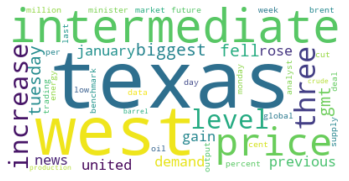

['three', 'level', 'increase', 'biggest', 'gmt', 'tuesday', 'fell', 'previous', 'demand', 'united', 'news', 'rose', 'january', 'gain', 'west', 'minister', 'data', 'since', 'future', 'last', 'percent', 'trading', 'low', 'global', 'deal', 'per', 'benchmark', 'energy', 'cut', 'texas', 'texas intermediate', 'west texas intermediate', 'intermediate', 'west texas', 'day', 'analyst', 'oil price', 'monday', 'brent', 'million', 'week', 'cent', 'supply', 'output', 'market', 'production', 'crude', 'barrel', 'price']
Topico 1:


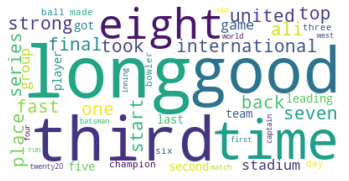

['long', 'good', 'like', 'third', 'time', 'eight', 'international', 'united', 'back', 'seven', 'strong', 'fast', 'final', 'get', 'top', 'series', 'one', 'place', 'ali', 'start', 'took', 'stadium', 'game', 'group', 'leading', 'five', 'team', 'got', 'second', 'last', 'player', 'champion', 'six', 'day', 'made', 'three', 'bowler', 'ball', 'twenty20', 'batsman', 'match', 'first', 'west', 'world', 'inning', 'captain', 'two', 'four', 'run']
Topico 2:


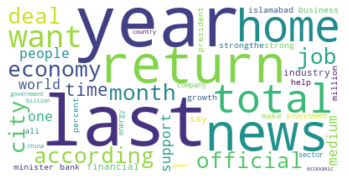

['return', 'news', 'home', 'total', 'want', 'according', 'economy', 'official', 'job', 'city', 'deal', 'month', 'time', 'people', 'last year', 'one', 'last', 'support', 'medium', 'world', 'industry', 'financial', 'say', '/strongthe', 'ali', 'minister', 'like', 'strong', 'make', 'president', 'islamabad', 'help', 'percent', 'business', 'growth', 'million', 'bank', 'investment', 'also', 'energy', 'year', 'company', 'sector', 'government', 'economic', 'country', 'china', 'billion', 'power']
Topico 3:


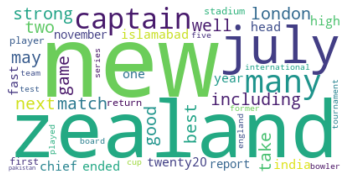

['july', 'many', 'captain', 'including', 'strong', 'may', 'london', 'match', 'two', 'since', 'well', 'next', 'best', 'good', 'game', 'take', 'twenty20', 'ended', 'chief', 'also', 'head', 'year', 'india', 'fast', 'islamabad', 'high', 'one', 'november', 'report', 'player', 'first', 'return', 'stadium', 'international', 'tournament', 'five', 'cup', 'board', 'bowler', 'former', 'series', 'played', 'new', 'new zealand', 'team', 'zealand', 'test', 'england', 'pakistan']
Topico 4:


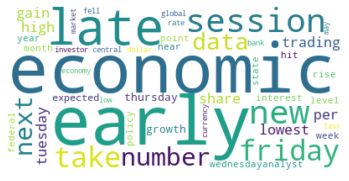

['economic', 'early', 'late', 'session', 'new', 'friday', 'take', 'number', 'next', 'data', 'trading', 'per', 'gain', 'high', 'tuesday', 'lowest', 'share', 'thursday', 'growth', 'expected', 'wednesday', 'analyst', 'interest', 'rise', 'point', 'week', 'year', 'near', 'month', 'hit', 'level', 'federal', 'state', 'policy', 'global', 'central', 'fell', 'may', 'last', 'economy', 'since', 'investor', 'low', 'currency', 'market', 'bank', 'rate', 'u.s.', 'dollar']


In [29]:
nmf  = NMF(n_components = num_clusters)
nmf.fit(tfidf_matrix)
for i in range(0,num_clusters):
    word_list=[]
    print("Topico %d:"% i)
    for j in nmf.components_.argsort()[i,-num_palavras:-1]:
        word_list.append(terms[j])
    word_text = text = " ".join(word_list)
    wordcloud = WordCloud(background_color="white").generate(word_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print(word_list)

LDA

In [30]:
def strip_proppers(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

def strip_proppers_POS(text):
    tagged = pos_tag(text.split())
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

corpo1 = noticias['content']
%time preprocess = [strip_proppers(doc) for doc in corpo]
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in texts]

%time lda = models.LdaModel(corpus, num_topics=estimativa_categorias, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

Wall time: 328 ms
Wall time: 629 ms
Wall time: 68 ms
Wall time: 27 s


In [31]:
topics = lda.print_topics(5, num_words=num_palavras)

lda.show_topics()

[(0,
  '0.011*"percent" + 0.009*"market" + 0.008*"last" + 0.006*"price" + 0.005*"year" + 0.005*"oil" + 0.005*"strong" + 0.005*"week" + 0.005*"two" + 0.005*"first"'),
 (1,
  '0.007*"tax" + 0.007*"power" + 0.006*"year" + 0.005*"also" + 0.005*"project" + 0.004*"compani" + 0.004*"billion" + 0.004*"strong" + 0.004*"countri" + 0.004*"percent"')]

['percent', 'market', 'last', 'price', 'year', 'oil', 'strong', 'week', 'two', 'first', 'also', 'sinc', 'trade', 'three', 'global', 'dollar', 'day', 'crude', 'barrel', 'fell']


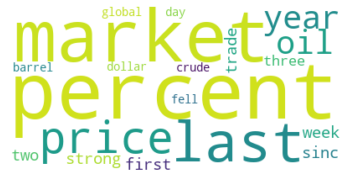


['tax', 'power', 'year', 'also', 'project', 'compani', 'billion', 'strong', 'countri', 'percent', 'help', 'system', 'news', 'million', 'new', 'last', 'one', 'govern', 'cricket', 'invest']


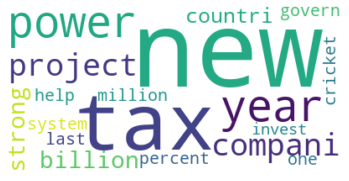

In [32]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,1]

for i in topic_words:
    print([word[0] for word in i])
    word_text = text = " ".join(word[0] for word in i)
    wordcloud = WordCloud(background_color="white").generate(word_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print()

Extracao de entidades

In [33]:
from spacy.matcher import PhraseMatcher
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
import networkx as nx
import pandas as pd
from collections import Counter
from pyvis.network import Network
import re

class EntityMatcher(object):
    name = "entity_matcher"

    def __init__(self, nlp, terms, label):
        patterns = [nlp.make_doc(text) for text in terms]
        self.matcher = PhraseMatcher(nlp.vocab)
        self.matcher.add(label, None, *patterns)

    def __call__(self, doc):
        matches = self.matcher(doc)
        for match_id, start, end in matches:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]
        return doc
    
    
def makeGraphFromSpacy(nlpList, minConnections = 1):
    """ Takes a list of document objects returned from sPaCy.
        Iterates through, takes the GPE, Person, and custom Themes from
        the spacy entities to construct the graph. Edges of the graph
        represent how often it occured, size of each node is fixed to degree
    """
    G = nx.Graph()
    colorMap = {'GPE':'Blue','PERSON':'Red','ORG':'Green','THEME':'Black'}

    for parNum, doc in enumerate(nlpList[0:len(nlpList)]):
        G.add_node(f"par_{parNum}", t = 'Paragraph', color = 'grey', text = doc.text) # Add a node for each paragraph
        #Get a count of all of the distinct occurences of an entity
        entCountDict = Counter([(ent.string.strip(),ent.label_) 
                                for ent in doc.ents 
                                if not bool(re.search(r":|\.", ent.text))  
                                and (ent.label_=='GPE' or 
                                     ent.label_ =='PERSON' or
                                     ent.label_ =='ORG' or
                                     ent.label_ =='THEME')])
        for ent,cnt in entCountDict.items():
            G.add_node(ent[0],label = ent[1], color = colorMap[ent[1]])
            #set the weight of the edge equal to the count of occurance
            G.add_edge(ent[0],f"par_{parNum}", weight = cnt)

    #minConnections allows you to prune the tree
    nodesToRemove = []
    for node in G.nodes():
        nodeDegree = G.degree(node)
        if nodeDegree >= 1:
            G.node[node]['value'] = nodeDegree
        else:
            nodesToRemove.append(node)

    for node in nodesToRemove:
        G.remove_node(node)
    G.number_of_nodes()
    return G

def from_nx(graphVizNet, nx_graph):
    """
    Custom from_nx function which captures colorls and titles. 
    This method is a bit fragile and highly dependant on the structure of the graph.
    I need to work to generalize
    """
    assert(isinstance(nx_graph, nx.Graph))
    edges = nx_graph.edges(data=True)
    nodes = nx_graph.nodes()
    if len(edges) > 0:
        for e in edges:
            #print('text' in nx_graph.node[e[0]] )
            graphVizNet.add_node(e[0], 
                label = str(e[0]), 
                title = multi_line_toolip(nx_graph.node[e[0]]['text']) if 'text' in nx_graph.node[e[0]] else e[0], 
                color = nx_graph.node[e[0]]['color'], 
                value = nx_graph.node[e[0]]['value']
            )

            graphVizNet.add_node(e[1], 
                label = e[1], 
                title = multi_line_toolip(nx_graph.node[e[1]]['text']) if 'text' in nx_graph.node[e[1]] else e[1],
                color = nx_graph.node[e[1]]['color'], 
                value = nx_graph.node[e[1]]['value']
            )

            graphVizNet.add_edge(e[0], e[1], value = nx_graph.edges[e[0],e[1]]['weight'])
    else:
        graphVizNet.add_nodes(nodes)
    return graphVizNet
def multi_line_toolip(aString: str):
    return(f'<a href="#" title="Line 1&#5;Line 2&#5;Line 3"> {aString}</a>')

def getFirstOrderGraph(graph, node):
    nodes = []
    [nodes.append(n) for n in graph.neighbors(node)]
    nodes += [node]
    subG = graph.subgraph(nodes)
    print(f"Nodes: {subG.number_of_nodes()}")
    print(f"Edges: {subG.number_of_edges()}")
    print(f"Self Loops: {subG.number_of_selfloops()}")
    return subG

def getSecondOrderSubgraph(graph, node):

    nodes = []
    for neighbor_list in [graph.neighbors(n) for n in graph.neighbors(node)]:
        for n in neighbor_list:
            nodes.append(n)
    nodes += [n for n in graph.neighbors(node)]
    subG = graph.subgraph(nodes)
    print(f"Nodes: {subG.number_of_nodes()}")
    print(f"Edges: {subG.number_of_edges()}")
    print(f"Self Loops: {subG.number_of_selfloops()}")
    return subG

def visualizeGraph(nxGraph, save = False, size = ['500px','500px']):
    """ Converts from networkx to a pyvis Network. 
    """
    subGViz = Network(size[0], size[1])
    from_nx(subGViz,nxGraph)
    
    if save:
        subGViz.save_graph(save)
    else:
        subGViz.write_html('graph.html')
        #subGViz.show('subGViz.html')
    return subGViz

def build_trimmed_subgraph(fullGraph, entity, n = 100000):
    """ 
    Takes an nx graph and a node name
    gets second order subgraph 
    and trims based on pagerank. 
    """
    subG = getSecondOrderSubgraph(fullGraph,entity)
    
    closeness = nx.algorithms.pagerank(subG)
    top_n_closeness = pd.DataFrame([closeness]).T.sort_values(0, ascending=False).head(n).reset_index()
    
    limited_sub_g = subG.subgraph(list(top_n_closeness['index']) + [entity])
    
    return limited_sub_g

In [34]:
nlp = en_core_web_sm.load()
for i in noticias['content']:
    word_text = text = " ".join(noticias['content'])
doc = nlp(word_text)
labels = [x.label_ for x in doc.ents]
Counter(labels)

Counter({'PERCENT': 147,
         'DATE': 755,
         'ORG': 673,
         'GPE': 818,
         'NORP': 219,
         'PERSON': 595,
         'MONEY': 184,
         'PRODUCT': 18,
         'CARDINAL': 527,
         'ORDINAL': 124,
         'QUANTITY': 33,
         'LOC': 65,
         'TIME': 31,
         'WORK_OF_ART': 9,
         'LAW': 2,
         'EVENT': 32,
         'FAC': 36,
         'LANGUAGE': 3})

In [35]:
parag = noticias['content']

In [36]:
#mParagraphs = noticias['content'] #flatten the list of lists
#len(mParagraphs)
termos = (u"collude", u"collusion", 
         u"conspiracy", u"conspire",u"hack", u"hacking", u"cyber intrusions", 
         u"russian hacking", u"hackers",u"social media",u"computer intrusions",
         u"cybersecurity",u"emails","email")
concept_matcher = EntityMatcher(nlp, termos, "THEME")
nlp.add_pipe(concept_matcher, after="ner")

In [37]:
nlpParagraphs= list(nlp.pipe(parag, n_threads=2, batch_size=1000))

In [38]:
fullG = makeGraphFromSpacy(nlpParagraphs)
pyvisG = Network("1000px", "1000px")
from_nx(pyvisG,fullG)
pyvisG.show_buttons(filter_=['physics'])
pyvisG.show('full.html')

Metricas

supervisionada

In [39]:
algos = {}
results = []
algos['kmeans'] = cluster.KMeans(n_clusters=num_clusters)
algos['affinity'] = cluster.AffinityPropagation()
algos['meanshift'] = cluster.MeanShift(bin_seeding = True)
algos['spectral'] = cluster.SpectralClustering(n_clusters = num_clusters, eigen_solver='arpack')
algos['ward'] = cluster.AgglomerativeClustering(n_clusters = num_clusters,linkage='ward')
algos['agglomerative'] = cluster.AgglomerativeClustering(linkage='average',affinity='cityblock',n_clusters=num_clusters)
algos['dbscan'] = cluster.DBSCAN(eps=epsilon)
algos['optics'] = cluster.OPTICS(min_samples=min_noticias)
algos['birch'] = cluster.Birch(n_clusters=num_clusters)
algos['minibatchkmeans'] = cluster.MiniBatchKMeans(n_clusters=num_clusters)

In [40]:
for model in algos.values():
    model.fit(tfidf_matrix)
    results.append(list(model.labels_))

In [41]:
nmi_result = []
ars_result = []
hom_result = []
vmea_result = []
y_true = []
y_pred = []
for i in dataset[var_publicacao]:
    if i == 'business':
        y_true.append(0)
    if i == 'sports':
        y_true.append(1)
print(y_true)
for y_pred in results:
    nmi_result.append(metrics.cluster.normalized_mutual_info_score(y_true, y_pred))
    ars_result.append(metrics.cluster.adjusted_rand_score(y_true, y_pred))
    hom_result.append(metrics.homogeneity_score(y_true, y_pred))
    vmea_result.append(metrics.v_measure_score(y_true, y_pred,beta=1.0))
print(nmi_result)
print(ars_result)
print(hom_result)
print(vmea_result)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\s

[0.5063078419043883, 0.4548938765465718, 2.0, 0.5122456384633658, 0.4688173325618215, 0.23824152966156376, 0.45520562147728777, 2.0, 0.4995005740254431, 0.5120390718105009]
[0.30614097898381154, 0.1421451353695075, 0.0, 0.3465131130329368, 0.27577873611125453, 0.08133756585617172, 0.43557730512198034, 0.0, 0.35459539884454494, 0.3767337543528301]
[0.7580469146734841, 0.875691154694158, 6.414258037651789e-16, 0.7592047162001885, 0.6848061119527357, 0.2503482737369782, 0.570785876155024, 6.414258037651789e-16, 0.7413475800343303, 0.742339580840269]
[0.46769569952638024, 0.37217541072100035, 1.282851607530357e-15, 0.4749999194161315, 0.43706285338360545, 0.23794915023064464, 0.44379680395225735, 1.282851607530357e-15, 0.46293958877664587, 0.4786451271563165]


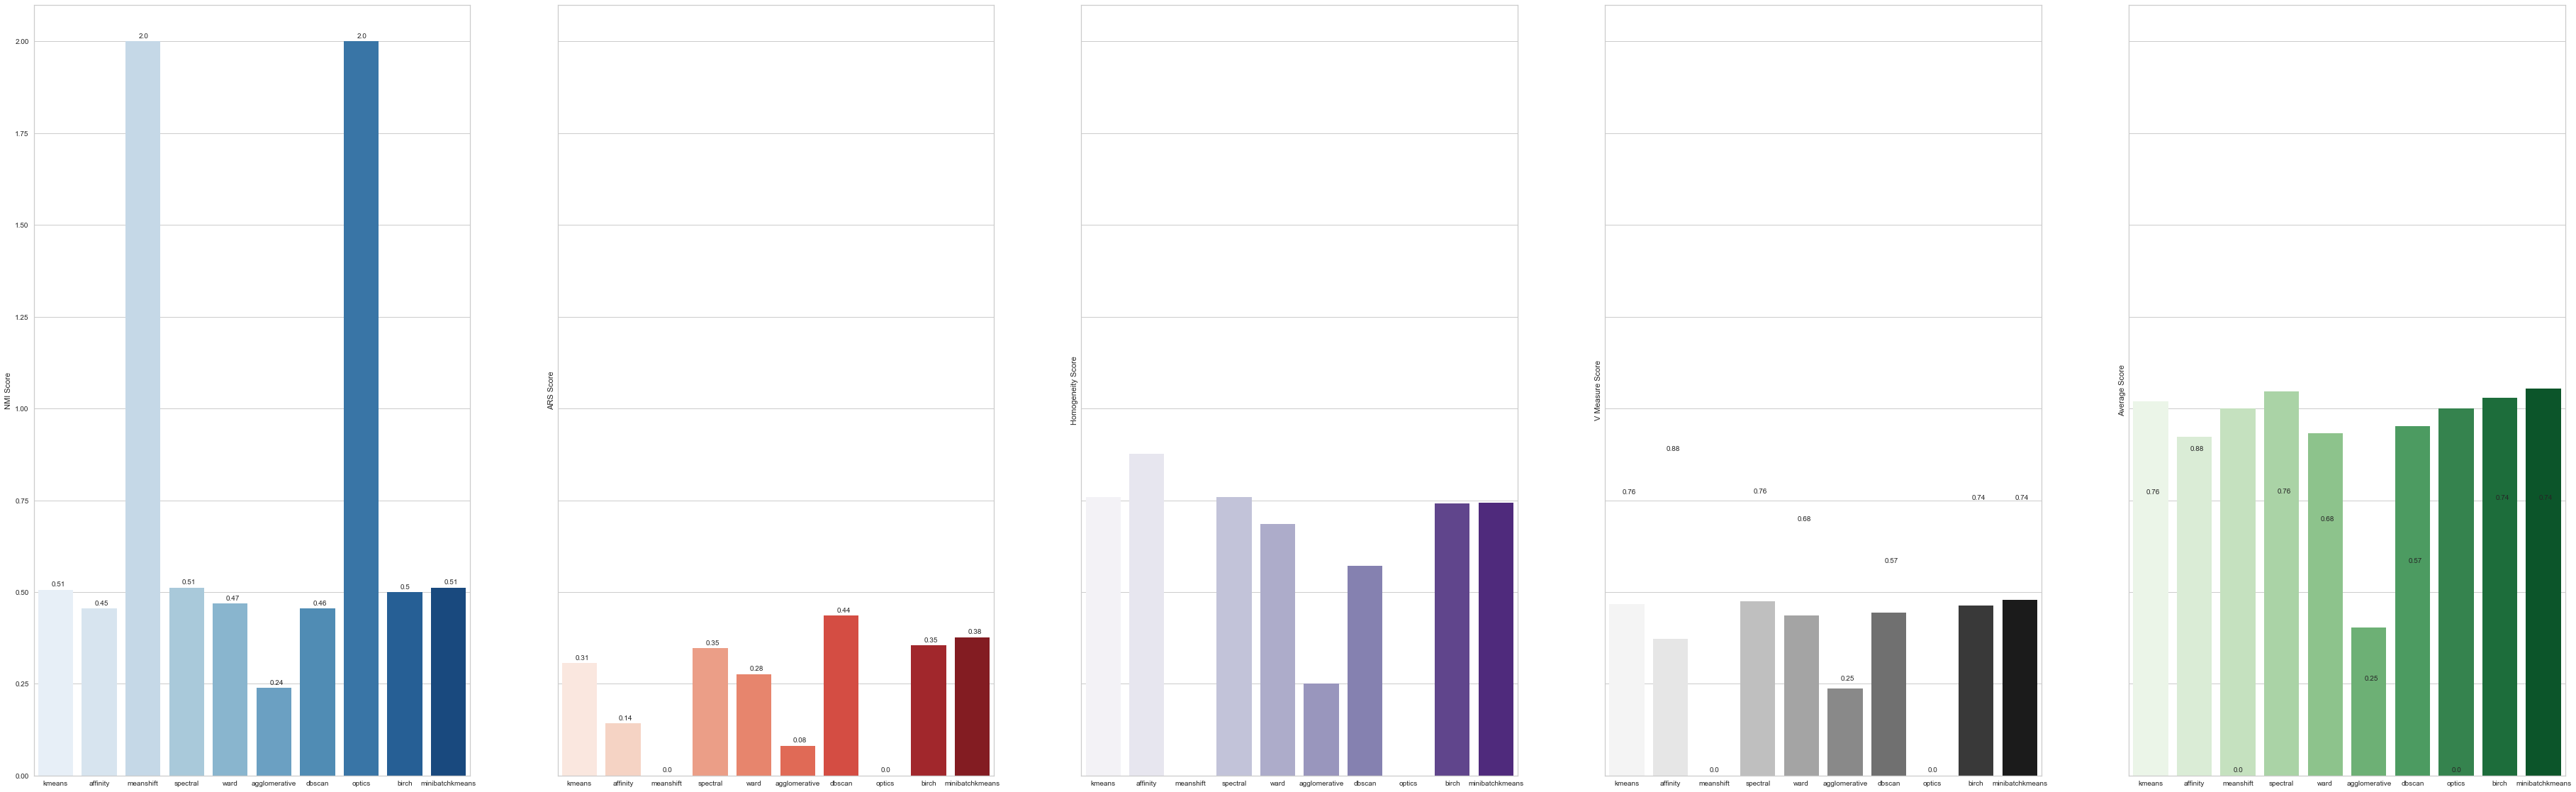

In [42]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=(64, 20))
x = np.arange(len(algos))
avg = [sum(x) / 2 for x in zip(nmi_result, ars_result,hom_result,vmea_result)]

xlabels = list(algos.keys())

sns.barplot(x, nmi_result, palette='Blues', ax=ax1)
sns.barplot(x, ars_result, palette='Reds', ax=ax2)
sns.barplot(x, hom_result, palette='Purples', ax=ax3)
sns.barplot(x, vmea_result, palette='Greys', ax=ax4)
sns.barplot(x, avg, palette='Greens', ax=ax5)

ax1.set_ylabel('NMI Score')
ax2.set_ylabel('ARS Score')
ax3.set_ylabel('Homogeneity Score')
ax4.set_ylabel('V Measure Score')
ax5.set_ylabel('Average Score')

# # Add the xlabels to the chart
ax1.set_xticklabels(xlabels)
ax2.set_xticklabels(xlabels)
ax3.set_xticklabels(xlabels)
ax4.set_xticklabels(xlabels)
ax5.set_xticklabels(xlabels)


# Add the actual value on top of each bar
for i, v in enumerate(zip(nmi_result, ars_result,hom_result,vmea_result, avg)):
    ax1.text(i - 0.1, v[0] + 0.01, str(round(v[0], 2)))
    ax2.text(i - 0.1, v[1] + 0.01, str(round(v[1], 2)))
    ax4.text(i - 0.1, v[2] + 0.01, str(round(v[2], 2)))
    ax5.text(i - 0.1, v[2] + 0.01, str(round(v[2], 2)))
# Show the final plot
plt.show()

Nao supervisionada